In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()


True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("practice")

LangSmith 추적을 시작합니다.
[프로젝트명]
practice


In [51]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Step 1: FAISS 인덱스 파일 로드
faiss_index_path = "faiss_index_naver_total"  # 저장된 Faiss 파일 경로
embeddings = OpenAIEmbeddings()  # 임베딩 객체 초기화

# 저장된 FAISS 인덱스를 불러와서 Retriever 생성
retriever_navermap = FAISS.load_local(faiss_index_path, embeddings,allow_dangerous_deserialization=True).as_retriever()

# 검색 매개변수 설정 (예: 검색 결과 상위 10개 반환)
retriever_navermap.search_kwargs = {"k": 10}

In [52]:
# Step 1: FAISS 인덱스 파일 로드
faiss_index_path = "faiss_opendata_index_combined"  # 저장된 Faiss 파일 경로
embeddings = OpenAIEmbeddings()  # 임베딩 객체 초기화

# 저장된 FAISS 인덱스를 불러와서 Retriever 생성
retriever_opendata = FAISS.load_local(faiss_index_path, embeddings,allow_dangerous_deserialization=True).as_retriever()

# 검색 매개변수 설정 (예: 검색 결과 상위 10개 반환)
retriever_opendata.search_kwargs = {"k": 10}

In [55]:
context = retriever_navermap.invoke(' 주소가 강남구의 카페 5개를 알려줘')
context

[Document(id='cabe43cc-7ba1-4734-b571-02a9b0651183', metadata={'source': {'data': 'map_crawling'}, 'store_info': {'store_name': '', 'category': ['카페'], 'rating': '별점 4.51', 'address': '서울 강남구 압구정로 461 네이처 포엠', 'phone_num': '02-548-6052', 'sns': 'http://www.coffeebeankorea.com/'}, 'business_info': {'business_hours': {}, 'parking': None, 'convenience_facilities_and_services': ['포장']}, 'review_info': {'visited_review': '방문자 리뷰 1,076', 'blog_review': '블로그 리뷰 55', 'review_like_this_part_output': '블로그 리뷰 55'}}, page_content="data: map_crawling\ncategory: ['카페']\nrating: 별점 4.51\naddress: 서울 강남구 압구정로 461 네이처 포엠\nphone_num: 02-548-6052\nsns: http://www.coffeebeankorea.com/\nconvenience_facilities_and_services: ['포장']\nvisited_review: 방문자 리뷰 1,076\nblog_review: 블로그 리뷰 55\nreview_like_this_part_output: 블로그 리뷰 55"),
 Document(id='cc47308b-29da-4475-aa6c-377b225c3157', metadata={'source': {'data': 'map_crawling'}, 'store_info': {'store_name': '', 'category': ['카페'], 'rating': '별점 4.31', 'address':

In [38]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [103]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context_naver: Annotated[str, "Context"]  # 문서의 검색 결과
    context_opendata: Annotated[str, "Context"]  # 문서의 검색 결과
    #context_web: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [104]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from operator import itemgetter
# 프롬프트
prompt = PromptTemplate(
    template="""너는  {context_opendata}, {context_naver}의 데이터를 종합해서 서울의 관광 일정을 추천해주는 봇이야.
    사용자의 질문에 따라서 여러가지 서울의 관광지, 식당, 숙소, 쇼핑몰 등을 추천해야해.
    처음에 사용자가 서울에 며칠동안 머무르는지 물어보고, 그에 따라서 관광 일정을 추천해주면 돼.
    그 다음 사용자가 서울에 오는 이유에 대해 파악하고 그에 맞는 여행 일정을 추천해주면 돼.
    대화하다가 추천한 여행 일정이 사용자의 마음에 들지 않아서 변경해달라고 하면 마음에 들지 않은 부분을
    캐치하고 그 부분들만 수정해서 다시 추천해주면 돼.
    일정 중간 중간 숙소나 식당, 쇼핑몰 등을 추천해주면 돼.

    어떤 장소가 궁금해서 물어본다면 특정 장소의 정보들을 정확하게 알려줘.
    (예:가게 정보, 메뉴, 별점, 위치, 연락처, 운영 시간, 리뷰 등)
    여행 일정에 대한 동선이 짧도록 추천해줘.
    언어는 사용자가 입력한 언어를 기준으로 알려줘. 
    화폐 기준도 사용자가 입력한 언어를 사용하는 국가의 화폐를 기준으로 적용해줘.




    # opendata 정보: {context_opendata}

    # naver 지도 : {context_naver}

    #사용자의 질문: {question}
    
    #이전 대화 내용 {chat_history} 
    """,
        input_variables=["context_opendata","context_naver", "question"],
    )
#input_variables=["context_web","context_opendata","context_naver", "question"],
    # 웹 검색 정보 : {context_web}
# LLM
model = ChatOpenAI(model_name="gpt-4o",
                    temperature=0, streaming=True)

chain = (
    {
        "question": itemgetter("question"),
        # "context_web": itemgetter("context_web"),
        "context_opendata": itemgetter("context_opendata"),
        "context_naver": itemgetter("context_naver"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [105]:
# from langchain_teddynote.tools.tavily import TavilySearch

# # 검색 도구 생성
# tavily_tool = TavilySearch()

# search_query = "서울시 용산구의 중식당은 뭐가 있지"

# # 다양한 파라미터를 사용한 검색 예제
# search_result = tavily_tool.search(
#     query=search_query,  # 검색 쿼리
#     max_results=3,  # 최대 검색 결과
#     format_output=True,  # 결과 포맷팅
# )

# # 검색 결과 출력
# print(search_result)

In [106]:
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch

# from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document_naver(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever_navermap.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = "\n".join(
        [
            f"<document><content>{doc.page_content}</content>"
            for doc in retrieved_docs
        ]
)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context_naver": retrieved_docs}

def retrieve_document_opendata(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever_opendata.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = "\n".join(
        [
            f"<document><content>{doc.page_content}</content>"
            for doc in retrieved_docs
        ]
)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context_opendata": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    # 검색된 문서를 상태에서 가져옵니다.
    context_naver = state["context_naver"]
    context_opendata = state["context_opendata"]
    #context_web = state["context_web"]

    # 체인을 호출하여 답변을 생성합니다.
    response = chain.invoke(
        {
            "question": latest_question,
           # "context_web": context_web,
            "context_naver": context_naver,
            "context_opendata": context_opendata,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"][-1].content

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=2,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context_web": search_result}


def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

In [107]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve_opendata", retrieve_document_opendata)
workflow.add_node("retrieve__naver", retrieve_document_naver)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("llm_answer", llm_answer)
#workflow.add_node("web_search", web_search)

# 엣지 정의
workflow.add_edge("query_rewrite", "retrieve_opendata")  # 검색 -> 답변
#workflow.add_edge("query_rewrite", "web_search")  # 질문 -> 검색
workflow.add_edge("query_rewrite", "retrieve__naver")  # 질문 -> 검색
#workflow.add_edge("web_search", "llm_answer")  
workflow.add_edge("retrieve_opendata", "llm_answer") 
workflow.add_edge("retrieve__naver", "llm_answer") 
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("query_rewrite")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

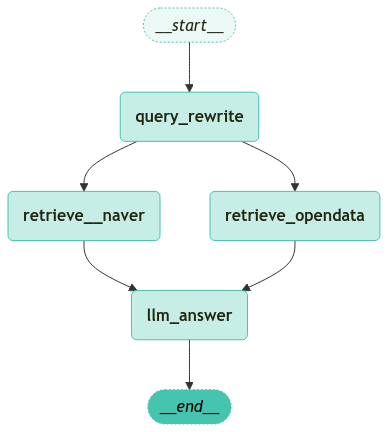

In [108]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [109]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="용산구에 1박2일을 머물거야 일정을 만들어 줄 수 있어?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
용산구에서 1박 2일 동안의 여행 일정을 추천해 줄 수 있나요?

🔄 Node: retrieve_opendata 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context_opendata:
<document><content>상호명: 서울김치문화체험관 
 콘텐츠URL: https://korean.visitseoul.net/entertainment/서울김치문화체험관/KOP005375?utm_source=seoulopendata&utm_medium=entertainment&utm_content=KOP005375 
 주소: 100-860 서울 중구 충무로2가 12-27 33-1 
 신주소: 04537 서울 중구 명동8가길 47 (충무로2가) 동양빌딩 2층 
 전화번호: 02-318-7051 
 웹사이트: http://www.seoulkimchi.co.kr 
 운영시간:  10:30 - 19:00 
 운영요일: 월~일 
 휴무일: 연중무휴 
 교통정보: 4호선 명동역 10번 출구 
 홈페이지 운영 언어: nan 
 유모차 대여 여부: nan</content>
<document><content>상호명: 동대문 관광안내소 
 콘텐츠URL: https://korean.visitseoul.net/attractions/동대문-관광안내소/KOP027215?utm_source=seoulopendata&utm_medium=attractions&utm_content=KOP027215 
 주소: 100-729 서울 중구 을지로6가 18-21  
 신주소: 04564 서울 중구 장충단로 247 (굿모닝시티쇼핑몰)  
 전화번호: +82-2-2236-9135 
 팩스번호: nan 
 웹사이트: http://www.sta.or.kr 
 운영시간: 10:00 ~ 01:00 
 운영요일: nan